In [1]:
#     from IPython.display import HTML

#     hide_me = ''
#     HTML('''<script>
#       function code_toggle() {
#         if (code_shown){
#           $('div.input').hide('500');
#           $('#toggleButton').val('Show Code')
#         } else {
#           $('div.input').show('500');
#           $('#toggleButton').val('Hide Code')
#         }
#         code_shown = !code_shown
#       }

#       $( document ).ready(function(){
#         code_shown=false;
#         $('div.input').hide()
#       });
#     </script>
#     <form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')


# 1) Goals:

Determine the cause of the bizarre calibration output. 
- Time varying $\alpha$
- $C(t)$ that crosses zero
- $\gamma$ that is about half of what it should be
- Sawtooth pattern
- Within the warm bath spatial gradient in temperature


## Try:  
- $\overline{\alpha(t)}$, use mean value instead of time varying
- Sub-section of warm bath for calibration (e.g., after break)
- Look into sawtooth error

<mark>- C(t) should not cross zero, that is weird.</mark>  
<mark>- $\gamma$ is too low</mark>  
<mark>- $\alpha$(t) is super noisy, suggests we should instead use the temporal average rather than letting the quantity jump each time step.</mark>


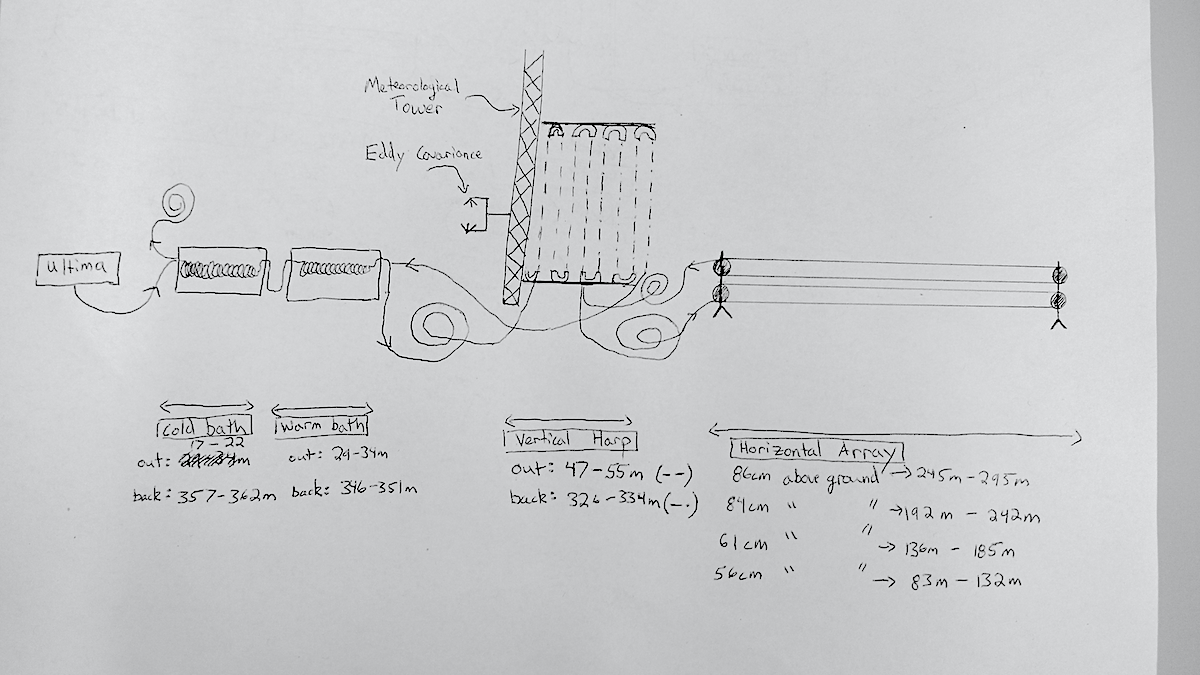

In [2]:
from IPython.core.display import Image 
Image(filename='/Users/karllapo/Desktop/proj/VertHarpExp2017Kloendeel/python/DTS/VertHarp.ExpDesign.jpg')


#### Sketch of the experimental set-up.
The Ultima is sampling a ~400m length of cable in a single-ended configuration. The cable runs runs out and then back, where it rests on the spool.
- On both the out and back the cable runs through a cold bath (which given our lack of ice is more of an ambient temperature bath) and a warm bath (~40C).
- On the tower we set up a vertical array of fiber optic cable to allow us to directly compare the eddy-covariance- and Ultima-derived temperatures. 
- We then run the cable out on a horizontal array, largely just to eat up cable before running the cable back to the vertical harp. 
- The main goal was to acquire a "near-Ultima" and "further-away-from-Ultima" comparison to understand how signal attenuation affects the spectral response of temperature observations.

In [3]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys
import pickle
import os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

# XML
import xmltodict

In [4]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists

# Find host name
import socket
if socket.gethostname().find('.')>=0:
    name=socket.gethostname()
else:
    name=socket.gethostbyaddr(socket.gethostname())[0]

# Determine which machine the script is running on; set up directory names
if 'btgmm8' in name:
    dirPre = '/Users/karllapo/Desktop/'
elif 'klapos' in name:
    dirPre = '/Users/karllapo/gdrive/DarkMix/'

dirData = dirPre + 'proj/VertHarpExp2017Kloendeel/data/DTS_UltimaVHSRE'
dirPrint = dirPre + 'graphics'
dirProcessed = dirPre + 'proj/VertHarpExp2017Kloendeel/data/DTS_UltimaVHSRE_processed'

In [5]:
#########################
## Load processed data ##
#########################
os.chdir(dirProcessed)
ncFiles = ['VHRSE_temp_chunk' + str(nFile) + '.nc' for nFile in np.arange(1, 16)]
ds = xr.open_mfdataset(ncFiles)

# Format locations descriptor
ds.attrs['locations'] = ds.attrs['locations'].split(';')

# Describe which PT100 goes in which calibration bath
ds['probeWarmBath'] = ds.probe1Temperature
ds['probeColdBath'] = ds.probe2Temperature


- probe1Temperature is the warm bath
- probe2Temperature is the cold bath

Future versions of read/processing code will somehow need to do affiliate each probe temperature with the bath name for the below calibration to function.
***

In [6]:
# Location labels for quickly identifying sections
location = {

    ########################
    ## Near vertical harp ##
    ########################
    'vertHarpNear' : [47.3, 54.9],

    #######################
    ## Far vertical harp ##
    #######################
    # Segment 1, up and over ~ 326.2 to 329.75. 2m vertical separation,
    # tentatively assign 326.2 to 327.7 as the upward limb.
    'vertHarpFar': [326.2, 333.75],


    ######################
    ## Horizontal Array ##
    ######################
    'Horizontal - 86cm': [245, 294.5],
    'Horizontal - 84cm': [192.25, 242],
    'Horizontal - 60.5cm': [136, 185.5],
    'Horizontal - 56cm': [82.5, 132],

    #######################
    ## Temperature Baths ##
    #######################
    'warmBathNear': [29, 34],
    'coldBathNear': [17, 22],
    'warmBathFar': [346, 351],
    'coldBathFar': [357, 362],
    }

/anaconda/lib/python3.6/site-packages/dask/array/core.py:476: RuntimeWarning: overflow encountered in true_divide
  o = func(*args, **kwargs)
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in log


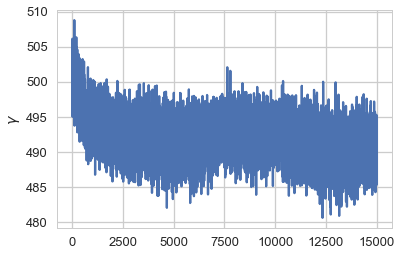

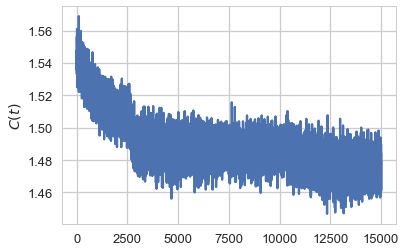

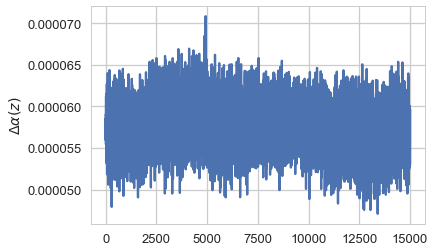

In [7]:
######################
## Matrix Inversion ##
######################

# Run the matrix inversion?
matrixInversionFlag = True

# Reference temperatures
refField1 = 'probeWarmBath' # Warm bath
refField2 = 'probeColdBath' # Cold bath
refField3 = 'probeWarmBath' # Warm bath
if matrixInversionFlag:
    refT1 = ds[refField1] + 273.15
    refT2 = ds[refField2] + 273.15
    refT3 = ds[refField3] + 273.15

    # Reference sections
    refLoc1 = 'warmBathFar'
    refLoc2 = 'coldBathFar'
    refLoc3 = 'warmBathNear'

    section1 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc1)
    section2 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc2)
    section3 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc3)

    ref_z1 = section1.LAF.mean(dim='location')
    ref_z2 = section2.LAF.mean(dim='location')
    ref_z3 = section3.LAF.mean(dim='location')

    # Amplitudes of stokes/anti-stokes
    stokesRatio1 = np.log(section1.Ps / section1.Pas).mean(dim='location')
    stokesRatio2 = np.log(section2.Ps / section2.Pas).mean(dim='location')
    stokesRatio3 = np.log(section3.Ps / section3.Pas).mean(dim='location')

    # Allocate the calibration variables and manual temperature
    gamma = np.ones(np.shape(ds.time.values)) * -9999.
    C = np.ones(np.shape(ds.time.values)) * -9999.
    delta_alpha = np.ones(np.shape(ds.time.values)) * -9999.
    manualTemp = np.ones(np.shape(ds.temp.values)) * -9999.

    # Within each time step solve for the calibration parameters
    for n, t in enumerate(ds.time):
        print('Time step ' + str(n) + ' of ' + str(np.size(ds.time.values)), end="\r", flush=True)


        # A matrix
        A = [[1, -refT1.sel(time=t), refT1.sel(time=t) * ref_z1],
             [1, -refT2.sel(time=t), refT2.sel(time=t) * ref_z2],
             [1, -refT3.sel(time=t), refT3.sel(time=t) * ref_z3],
            ]

        # b matrix
        b = [[refT1.sel(time=t) * stokesRatio1.sel(time=t)],
             [refT2.sel(time=t) * stokesRatio2.sel(time=t)],
             [refT3.sel(time=t) * stokesRatio3.sel(time=t)],
            ]

        x = np.linalg.solve(A, b)

        gamma[n] = x[0]
        C[n] = x[1]
        delta_alpha[n] = x[2]
        
        #############################
        ## Recalculate temperature ##
        #############################
        manualTemp[n] = gamma[n] / (np.log(ds.Ps.sel(time=t) / ds.Pas.sel(time=t)) + C[n] - delta_alpha[n] * ds.LAF)

    # Assign calibrated temperature to dataset
    ds['manualTemp'] = (('time', 'LAF'), manualTemp - 273.15)
        
    ##############################
    ## Plot Calibration Results ##
    ##############################
    plt.plot(gamma)
    plt.gca().set_ylabel('$\gamma$')

    plt.figure()
    plt.plot(C)
    plt.gca().set_ylabel('$C(t)$')

    plt.figure()
    plt.plot(delta_alpha)
    plt.gca().set_ylabel(r'$\Delta  \alpha (z)$')


# 5) Results

## Spatial evaluation
This is the calibrated temperature using the reference sections from the near and far warm bath and the far cold bath. Results are averaged in time and reported spatially.

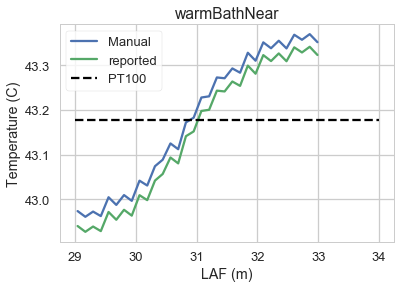

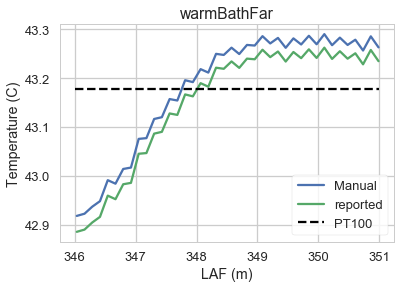

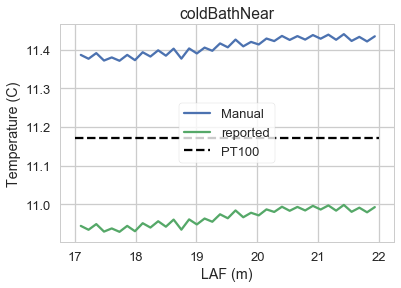

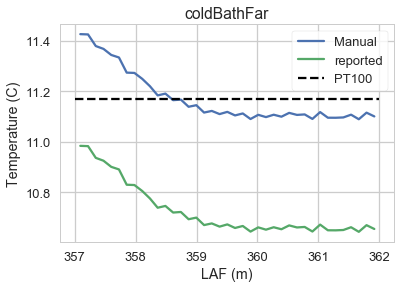

In [8]:
## Near warm bath
loc = 'warmBathNear'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot([location['warmBathNear'][0], location['warmBathNear'][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Far warm bath
loc = 'warmBathFar'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Near cold bath
loc = 'coldBathNear'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')

## Far cold bath
loc = 'coldBathFar'
plt.figure()
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='Manual')
plt.plot(ds.LAF.swap_dims({'LAF': 'location'}).sel(location=loc),
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='time'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot([location[loc][0], location[loc][1]],
          [probe_ds.mean(dim='time'), probe_ds.mean(dim='time')], 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')
plt.gca().set_xlabel('LAF (m)')


<mark>- There appears to be a really bad saw-tooth pattern. This needs further lab testing, since it is larger than sawtooth artefacts that John has encountered in other experiments.</mark>


## Temporal evaluation

Same as before except the results are spatially and reported as a function of time.

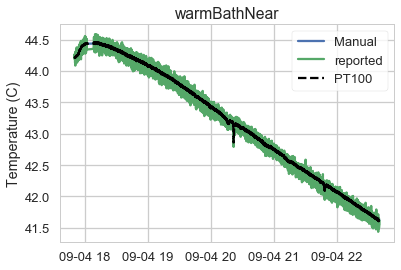

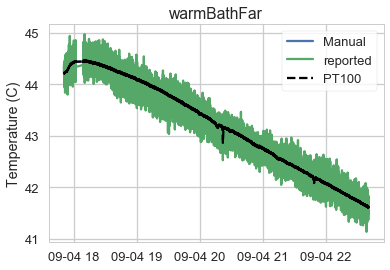

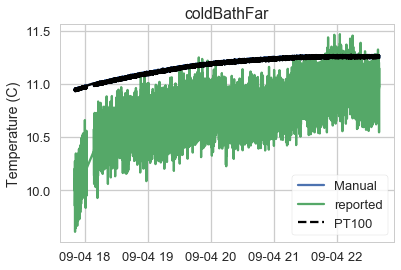

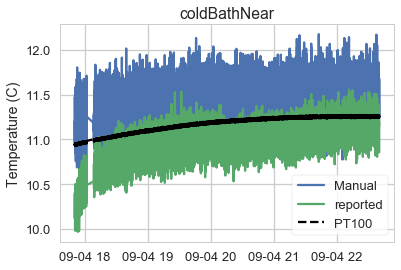

In [9]:
## Near warm bath
loc = 'warmBathNear'
plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Far warm bath
loc = 'warmBathFar'
plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe1Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Far cold bath
loc = 'coldBathFar'

plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Near cold bath
loc = 'coldBathNear'

plt.figure()
plt.plot(ds.time, 
         ds.manualTemp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='Manual')
plt.plot(ds.time,
         ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc).mean(dim='location'),
         label='reported')

probe_ds = ds.probe2Temperature
plt.plot(probe_ds.time, probe_ds, 'k--', label='PT100')

plt.legend(frameon=True)
plt.gca().set_title(loc)
plt.gca().set_ylabel('Temperature (C)')

## Evaluation metrics

This is just a series of graphs showing the RMSE and bias for each calibration.

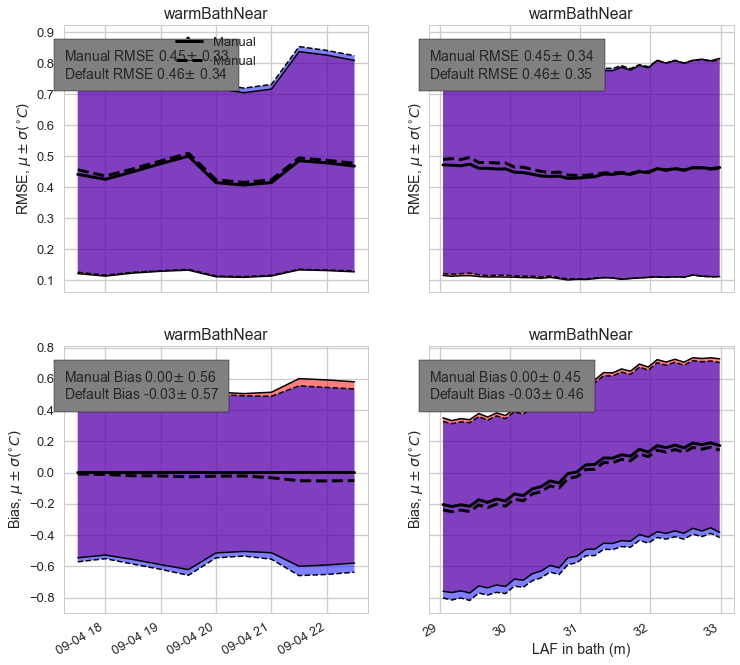

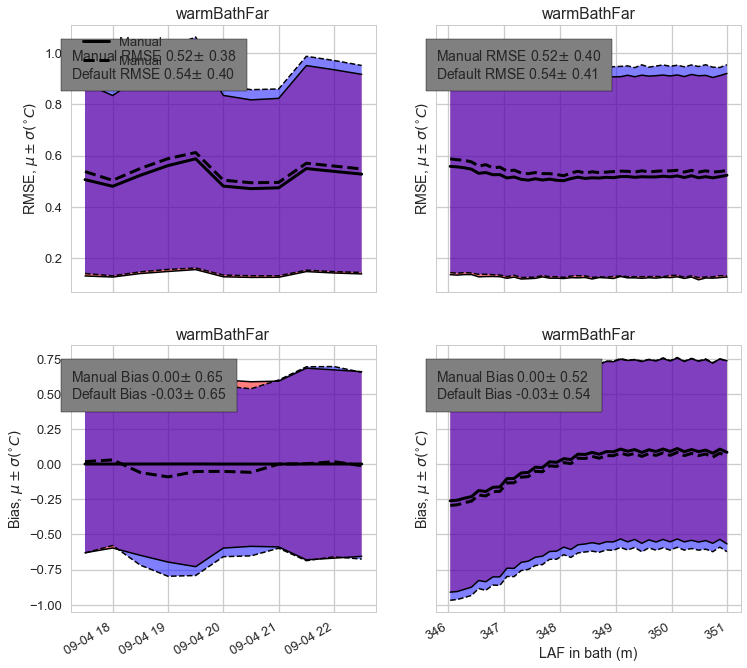

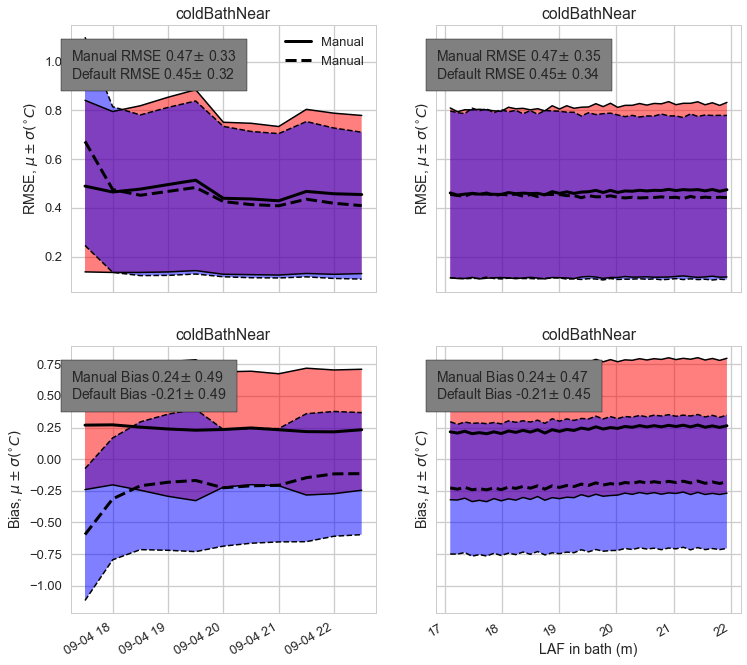

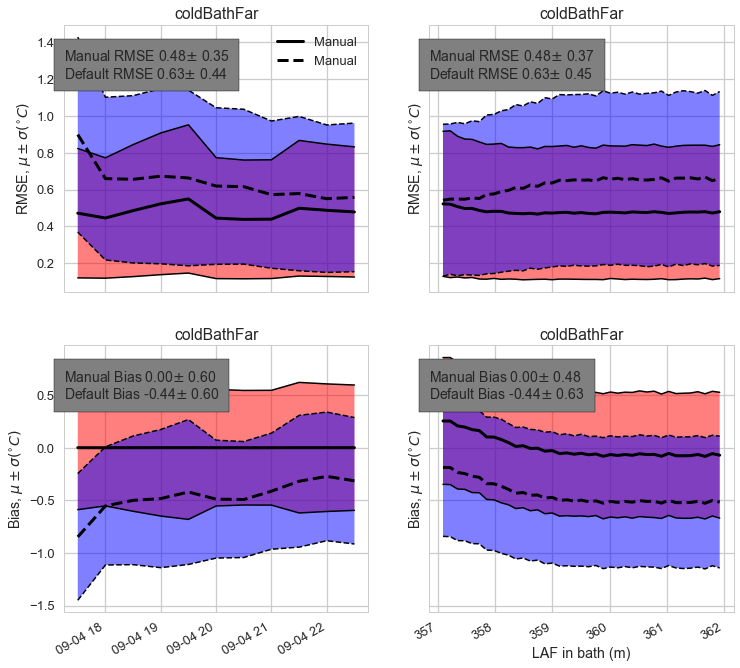

In [84]:
def rmse_ds(model, obs):
    meanRMSETime = np.sqrt((model - obs) ** 2).mean(dim='time')
    stdRMSETime = np.sqrt((model - obs) ** 2).std(dim='time')
    
    meanRMSELoc = np.sqrt((model - obs) ** 2).mean(dim='location')
    stdRMSELoc = np.sqrt((model - obs) ** 2).std(dim='location')
    
    return(meanRMSETime, stdRMSETime, meanRMSELoc, stdRMSELoc)

def bias_ds(model, obs):
    meanBiasTime = (model - obs).mean(dim='time')
    stdBiasTime = (model - obs).std(dim='time')
    
    meanBiasLoc = (model - obs).mean(dim='location')
    stdBiasLoc = (model - obs).std(dim='location')
    return(meanBiasTime, stdBiasTime, meanBiasLoc, stdBiasLoc)
    
def fillBetweenHelper(meanValueDataset, stdValueDataset):
    meanVal = meanValueDataset
    stdVal = stdValueDataset
    fillLow =  np.ma.masked_array(meanVal - stdVal, np.isnan(meanVal - stdVal))
    fillHigh =  np.ma.masked_array(meanVal + stdVal, np.isnan(meanVal + stdVal))
    return(meanVal, stdVal, fillLow, fillHigh)

def plotHelper(dsMean, dsSTD, ax, xPlotVar, label, ls='--', color='k', lw=3, **kwargs):
    meanVal, stdVal, fillLow, fillHigh = fillBetweenHelper(dsMean, dsSTD)
    ax.fill_between(meanVal[xPlotVar].values, fillLow, fillHigh, **kwargs)
    ax.plot(meanVal[xPlotVar], meanVal, ls=ls, color=color, lw=lw, label='Manual')
    ax.plot(meanVal[xPlotVar], fillLow, ls=ls, color=color, lw=lw/2)
    ax.plot(meanVal[xPlotVar], fillHigh, ls=ls, color=color, lw=lw/2)
    
## Plotting function
def plotRoutine(ds, probe_ds, loc):

    (meanRMSETimeManual, stdRMSETimeManual,
     meanRMSELocManaul, stdRMSELocManual) = rmse_ds(ds.manualTemp.swap_dims({'LAF': 'location'}).\
                                                    sel(location=loc), probe_ds)

    (meanBiasTimeManual, stdBiasTimeManual,
     meanBiasLocManaul, stdBiasLocManual) = bias_ds(ds.manualTemp.swap_dims({'LAF': 'location'}).\
                                                    sel(location=loc), probe_ds)

    (meanRMSETimeDefault, stdRMSETimeDefault,
     meanRMSELocDefault, stdRMSELocDefault) = rmse_ds(ds.temp.swap_dims({'LAF': 'location'}).\
                                                      sel(location=loc), probe_ds)

    (meanBiasTimeDefault, stdBiasTimeDefault,
     meanBiasLocDefault, stdBiasLocDefault) = bias_ds(ds.temp.swap_dims({'LAF': 'location'}).\
                                                      sel(location=loc), probe_ds)

    #############################
    ## Plot Evaluation Metrics ##
    #############################
    fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey='row', sharex='col')
    axes = axes.flatten()

    ## Location averaged RMSE
    ax = axes[0]
    ax.set_title(loc)

    # Manual calibration
    plotHelper(meanRMSELocManaul.resample(how='mean', dim='time', freq='0.5H'),
               stdRMSELocManual.resample(how='mean', dim='time', freq='0.5H'),
               ax, 'time', label='Manual', ls='-', facecolor='r', alpha=0.5)

    # Instrument calibration
    plotHelper(meanRMSELocDefault.resample(how='mean', dim='time', freq='0.5H'),
               stdRMSELocDefault.resample(how='mean', dim='time', freq='0.5H'),
               ax, 'time', label='Default', ls='--', facecolor='b', alpha=0.5)

    ax.set_ylabel('RMSE, $ \mu \pm \sigma  (^{\circ} C)$')
    ax.legend()
    ax.text(0, 0.8, 'Manual RMSE ' + '{:3.2f}'.format(np.mean(meanRMSELocManaul.values)) + '$\pm$ '
            + '{:3.2f}'.format(np.mean(stdRMSELocManual.values)) + '\n'
            + 'Default RMSE ' + '{:3.2f}'.format(np.mean(meanRMSELocDefault.values)) + '$\pm$ '
            + '{:3.2f}'.format(np.mean(stdRMSELocDefault.values)),
            transform = ax.transAxes, fontsize=14,
            bbox={'facecolor':'gray', 'pad':10})

    ## Time averaged RMSE
    ax = axes[1]
    ax.set_title(loc)

    # Manual calibration
    plotHelper(meanRMSETimeManual, stdRMSETimeManual, ax, 'LAF', label='Manual', ls='-', facecolor='r', alpha=0.5)

    # Instrument calibration
    plotHelper(meanRMSETimeDefault, stdRMSETimeDefault, ax, 'LAF', label='Default', ls='--', facecolor='b', alpha=0.5)

    ax.set_ylabel('RMSE, $ \mu \pm \sigma  (^{\circ} C)$')
    ax.set_xlabel('LAF in bath (m)')
    ax.text(0, 0.8, 'Manual RMSE ' + '{:3.2f}'.format(np.mean(meanRMSETimeManual.values)) + '$\pm$ '
            + '{:3.2f}'.format(np.mean(stdRMSETimeManual.values)) + '\n'
            + 'Default RMSE ' + '{:3.2f}'.format(np.mean(meanRMSETimeDefault.values)) + '$\pm$ '
            + '{:3.2f}'.format(np.mean(stdRMSETimeDefault.values)),
            transform = ax.transAxes, fontsize=14,
            bbox={'facecolor':'gray', 'pad':10})


    ## Location averaged Bias
    ax = axes[2]
    ax.set_title(loc)

    # Manual calibration
    plotHelper(meanBiasLocManaul.resample(how='mean', dim='time', freq='0.5H'),
               stdBiasLocManual.resample(how='mean', dim='time', freq='0.5H'),
               ax, 'time', label='Manual', ls='-', facecolor='r', alpha=0.5)

    # Instrument calibration
    plotHelper(meanBiasLocDefault.resample(how='mean', dim='time', freq='0.5H'),
               stdBiasLocDefault.resample(how='mean', dim='time', freq='0.5H'),
               ax, 'time', label='Default', ls='--', facecolor='b', alpha=0.5)

    ax.set_ylabel('Bias, $ \mu \pm \sigma  (^{\circ} C)$')
    ax.text(0, 0.8, 'Manual Bias ' + '{:3.2f}'.format(np.mean(meanBiasLocManaul.values)) + '$\pm$ '
            + '{:3.2f}'.format(np.mean(stdBiasLocManual.values)) + '\n'
            + 'Default Bias ' + '{:3.2f}'.format(np.mean(meanBiasLocDefault.values)) + '$\pm$ '
            + '{:3.2f}'.format(np.mean(stdBiasLocDefault.values)),
            transform = ax.transAxes, fontsize=14,
            bbox={'facecolor':'gray', 'pad':10})


    ## Time averaged Bias
    ax = axes[3]
    ax.set_title(loc)

    # Manual calibration
    plotHelper(meanBiasTimeManual, stdBiasTimeManual, ax, 'LAF', label='Manual', ls='-', facecolor='r', alpha=0.5)

    # Instrument calibration
    plotHelper(meanBiasTimeDefault, stdBiasTimeDefault, ax, 'LAF', label='Default', ls='--', facecolor='b', alpha=0.5)

    ax.set_ylabel('Bias, $ \mu \pm \sigma  (^{\circ} C)$')
    ax.set_xlabel('LAF in bath (m)')
    ax.text(0, 0.8, 'Manual Bias ' + '{:3.2f}'.format(np.mean(meanBiasTimeManual.values)) + '$\pm$ '
            + '{:3.2f}'.format(np.mean(meanRMSETimeManual.values)) + '\n'
            + 'Default Bias ' + '{:3.2f}'.format(np.mean(meanBiasTimeDefault.values)) + '$\pm$ '
            + '{:3.2f}'.format(np.mean(meanRMSETimeDefault.values)),
            transform = ax.transAxes, fontsize=14,
            bbox={'facecolor':'gray', 'pad':10})

    fig.autofmt_xdate()

baths = 'warmBathNear', 'warmBathFar', 'coldBathNear', 'coldBathFar'
for b in baths:
    if 'warm' in b:
        probe_ds = ds.probeWarmBath
    elif 'cold' in b:
        probe_ds = ds.probeColdBath
    plotRoutine(ds, probe_ds, b)

Left column: time averaged rmse and bias $\pm$ standard deviation.  
Right column: spatially averaged rmse and bias $\pm$ standard deviation

The mean value is stated in the upper left text box. The manually calibrated values do not seem to improve the DTS.

# Using $\overline{\Delta \alpha (t)}$ instead of $\Delta \alpha (t)$
From the calibration routine, the calibrated parameters are shown below. These are copy-pasted results (not dynamically created by running the above code with the flag set to True.



In [10]:
# ## Solve for delta alpha by interpolating between two reference baths
# refFieldWarm = 'probe1Temperature' # Warm bath
# refFieldCold = 'probe2Temperature' # Cold bath

# refTWarm = ds[refField1]
# refTCold = ds[refField2]

# # Reference sections
# refLoc1 = 'coldBathNear'
# refLoc2 = 'coldBathFar'

# section1 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc1)
# section2 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc2)

# ref_z1 = section1.LAF.mean(dim='location')
# ref_z2 = section2.LAF.mean(dim='location')

# # Amplitudes of stokes/anti-stokes
# stokesRatio1 = np.log(section1.Ps / section1.Pas).mean(dim='location')
# stokesRatio2 = np.log(section2.Ps / section2.Pas).mean(dim='location')

# deltaAlpha = (stokesRatio2 - stokesRatio1) / (ref_z2 - ref_z1)
# deltaAlphaMean = deltaAlpha.mean(dim='time').values
# plt.plot(deltaAlpha)
# plt.text(400, 0.000051, str(deltaAlpha.mean(dim='time').values))

Same order of magnitude, qualitatively similar shape to the matrix inversion parameter value.

_*NOTE*_ There is a sign error in equation 5 of Hausner 2011.

In [11]:
# # Now to solve for gamma and C directly
# # Run the matrix inversion?
# matrixInversionFlag = True

# # Reference temperatures
# refField1 = 'probe1Temperature' # Warm bath
# refField2 = 'probe2Temperature' # Cold bath
# refT1 = ds[refField1]
# refT2 = ds[refField2]

# if matrixInversionFlag:
#     # Reference sections
#     refLoc1 = 'warmBathNear'
#     refLoc2 = 'coldBathFar'

#     section1 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc1)
#     section2 = ds.swap_dims({'LAF': 'location'}).sel(location=refLoc2)

#     ref_z1 = section1.LAF.mean(dim='location')
#     ref_z2 = section2.LAF.mean(dim='location')

#     # Amplitudes of stokes/anti-stokes
#     stokesRatio1 = np.log(section1.Ps / section1.Pas).mean(dim='location')
#     stokesRatio2 = np.log(section2.Ps / section2.Pas).mean(dim='location')

#     # Allocate the calibration variables
#     gamma = np.ones(np.shape(ds.time.values)) * -9999.
#     C = np.ones(np.shape(ds.time.values)) * -9999.

#     # Within each time step solve for the calibration parameters
#     for n, t in enumerate(ds.time):
#         print("\r", 'Time step ' + str(n) + ' of ' + str(np.size(ds.time.values)), end="")


#         # A matrix
#         A = [[1, -refT1.sel(time=t).values],
#              [1, -refT2.sel(time=t).values]
#             ]

#         # b matrix
#         b = [[refT1.sel(time=t).values * stokesRatio1.sel(time=t).values
#               - deltaAlphaMean * ref_z1.values * refT1.sel(time=t).values],
#              [refT2.sel(time=t).values * stokesRatio2.sel(time=t).values
#               - deltaAlphaMean * ref_z2.values * refT2.sel(time=t).values],
#             ]

#         x = np.linalg.solve(A, b)

#         gamma[n] = x[0]
#         C[n] = x[1]
        
#     ##############################
#     ## Plot Calibration Results ##
#     ##############################
#     plt.plot(gamma)
#     plt.gca().set_ylabel('$\gamma$')

#     plt.figure()
#     plt.plot(C)
#     plt.gca().set_ylabel('$C(t)$')

The calibrated temperatures absolutely nail the far and near warm baths, but have issues with the near cold bath (albeit with a better result than the instrument reported temperatures) but worse results for the near warm bath. This combination of reference sections yields the best results.

In [12]:
# hide_me = ''
# HTML('''<script>
#   $(document).ready(function(){
#     $('div.prompt').hide();
#     $('div.back-to-top').hide();
#     $('nav#menubar').hide();
#     $('.breadcrumb').hide();
#     $('.hidden-print').hide();
#     $('div.output_stderr').hide();
#   });
# </script>''')

NameError: name 'HTML' is not defined